# Full version coming soon...
---

In [4]:
import os

########################################################################
import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import cv2 as cv

########################################################################
from deepdreaming import img, utils, deepdream as dd
from deepdreaming.utils import read_image_net_classes
from deepdreaming.config import DreamConfig, GradSmoothingMode

########################################################################
SEED = 42


def set_seeds(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seeds(SEED)
########################################################################
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
TARGET_SHAPE = (224, 224, 3)
IMAGE_NET_CLASSES_PATH = "input/image_net_classes/imagenet_classes.txt"
INPUT_IMAGES_DIR = "input/deepdream-sample-images"
OUTPUT_IMAGES_DIR = "output"

assert os.path.exists(IMAGE_NET_CLASSES_PATH), "Please provide a valid `IMAGE_NET_CLASSES_PATH`"
assert os.path.exists(INPUT_IMAGES_DIR), "Please provide a valid `INPUT_IMAGES_DIR`"
assert os.path.exists(OUTPUT_IMAGES_DIR), "Please provide a valid `DEEPDREAM_OUTPUT_PATH`"


#########################################
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = vgg16
WEIGHTS = VGG16_Weights.DEFAULT
#########################################

MODEL = MODEL_TYPE(weights=WEIGHTS).to(DEVICE).eval()
MODEL.requires_grad_(False)
IMAGE_NET_CLASSES = read_image_net_classes(IMAGE_NET_CLASSES_PATH)

/home/vlad/source/deepdreaming/deepdreaming/smoothing.py:89: UserWarning: 
        Kernel weights don't sum up to 1:
            Weights: (10, 2, 3)
            Their sum: 15
        Weights will be normalized implicitly.
        
  warnings.warn(


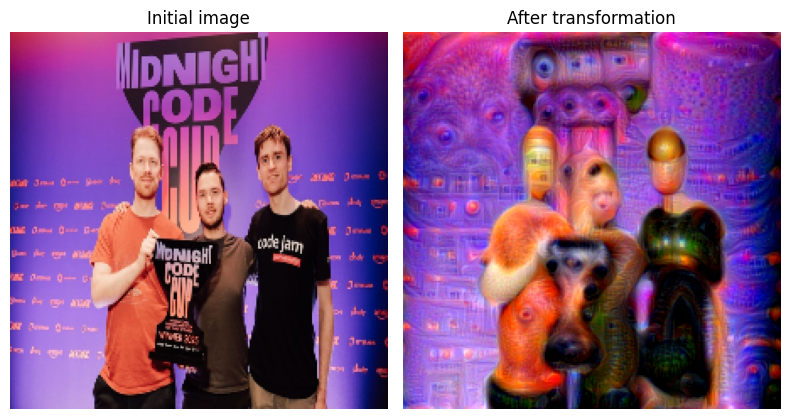

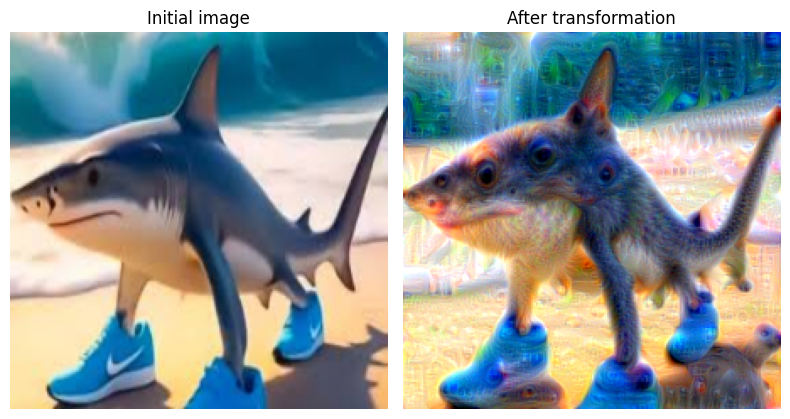

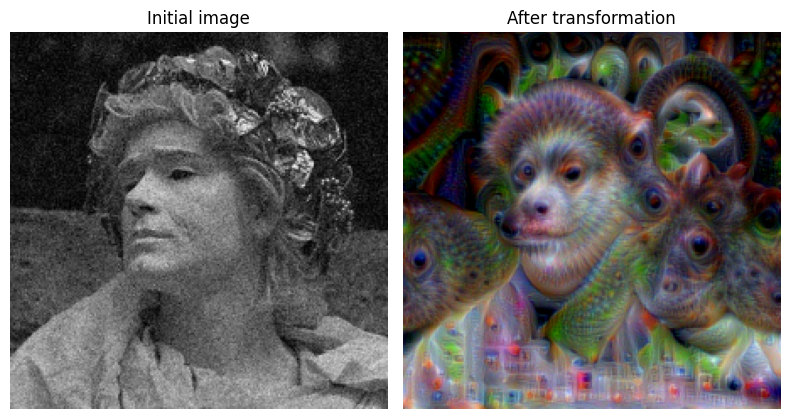

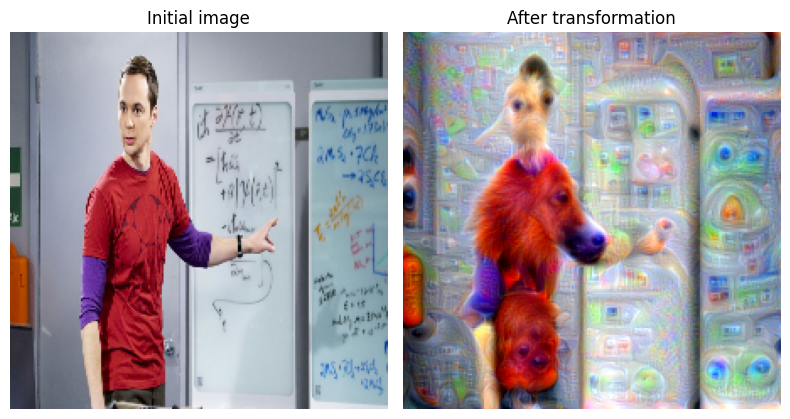

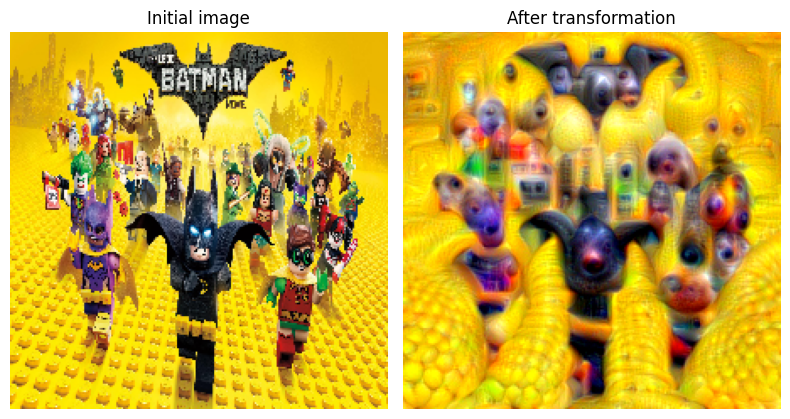

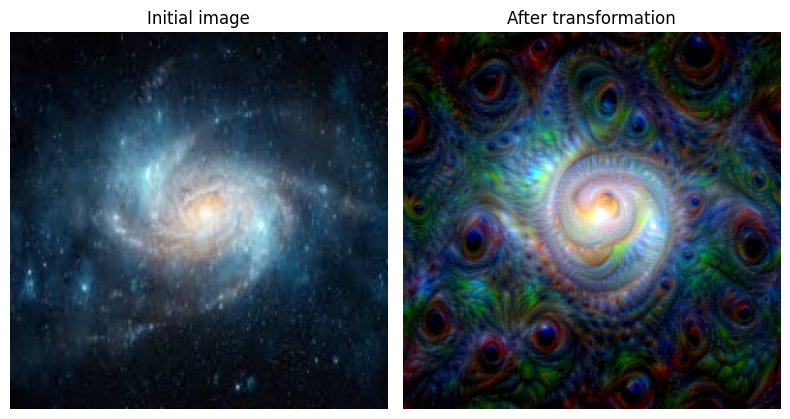

In [6]:
# deepdream = dd.DeepDream(MODEL, ["layer3[5].relu"])
deepdream = dd.DeepDream(MODEL, ["features[13]", "features[22]", "features[25]", "features[27]"])
# deepdream = dd.DeepDream(MODEL, ["Conv2d_1a_3x3.conv"])
sample_images = [os.path.join(INPUT_IMAGES_DIR, file_name) for file_name in os.listdir(INPUT_IMAGES_DIR)]
sample_config = DreamConfig(
    pyramid_layers=5,
    pyramid_ratio=3 / 4,
    shift_size=128,
    num_iter=10,
    learning_rate=0.08,
    grad_smoothing=GradSmoothingMode.GaussianSmoothing,
    grad_smoothing_kernel_size=5,
    grad_smoothing_gaussian_sigmas=(0.5, 1, 1.5),
    grad_smoothing_gaussian_blending_weights=(10, 2, 3),
)

# nice configs:
# num_iter = 10
#   -> layers=9, ratio=4/5
#   -> layers=3, ratio=0.42

sample_images[0] = os.path.join(INPUT_IMAGES_DIR, "guys.jpg")
for sample_image in sample_images[::3]:
    # read 'n' dream
    image: np.ndarray = img.io.read_image(sample_image, TARGET_SHAPE)
    out = deepdream.dream(image, config=sample_config)

    # compare 'n' show
    utils.display_two_img(image, out, figsize=(8, 8))
    plt.show()

    # transform for OpenCV
    out = img.proc.to_cv(out)

    # save
    file = f"{sample_image.split('/')[-1]}"
    fullpath = os.path.join(OUTPUT_IMAGES_DIR, file)
    success = cv.imwrite(fullpath, out)
    assert success, f"Image {fullpath} is not saved successfully..."

## Using reference image
**Dreaming with the reference image provided**

In [7]:
def get_path(prefix: str, name: str) -> str:
    return os.path.join(prefix, name)


# some experimental layer with cool results - feel free to change!
deepdream = dd.DeepDream(MODEL, ["features[22]"])

# config for guided deepdream
guided_dream_config = DreamConfig(gradient_norm=True, pyramid_layers=4, num_iter=10)

### `Yoda` guided by `Tree`

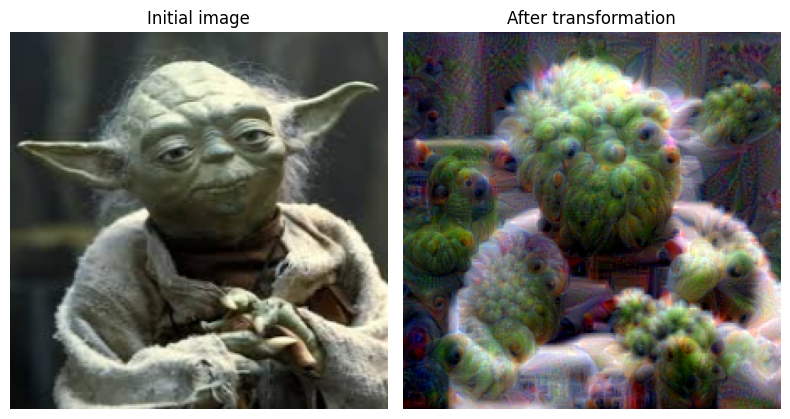

In [11]:
image = img.io.read_image(get_path(INPUT_IMAGES_DIR, "yoda.jpeg"), TARGET_SHAPE)
reference = img.io.read_image(get_path(INPUT_IMAGES_DIR, "tree.png"), TARGET_SHAPE)

out = deepdream.dream_guided(image, reference, config=guided_dream_config)
utils.display_two_img(image, out, figsize=(8, 8))

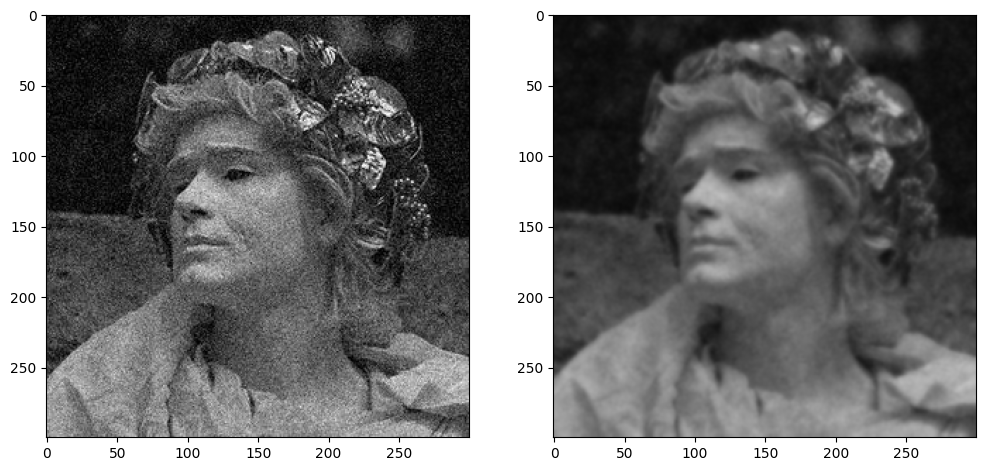

In [12]:
from deepdreaming import smoothing

fig, axis = plt.subplots(1, 2, figsize=(12, 12))
ax0, ax1 = axis.flatten()

image = img.io.read_image("/home/vlad/source/deepdreaming/input/deepdream-sample-images/noisy_image.jpg")
ax0.imshow(image)
image = img.proc.to_tensor(image)

out = smoothing.gaussian_smoothing(image, kernel_size=9, sigma=(1, 2, 3))
out = img.proc.to_image(out)
ax1.imshow(out)